In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np
import tensorflow as tf
import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

In [ ]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/dm-turtle-recall/train.csv \
    -O /content/train.csv

--2021-12-17 18:23:00--  https://storage.googleapis.com/dm-turtle-recall/train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66538 (65K) [text/csv]
Saving to: ‘/content/train.csv’

/content/train.csv  100%[===================>]  64.98K  --.-KB/s    in 0.001s  

2021-12-17 18:23:00 (90.4 MB/s) - ‘/content/train.csv’ saved [66538/66538]



In [ ]:
import pandas as pd
url='/content/train.csv'
train=pd.read_csv(url)

In [ ]:
train.turtle_id = pd.Categorical(train.turtle_id)
train['class'] = train.turtle_id.cat.codes

In [ ]:
train.head()

,image_id,image_location,turtle_id,class
0,ID_2RK4WLN8,top,t_id_VP2NW7aV,57
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC,91
2,ID_RVATH2HZ,Right,t_id_3b65X5Lw,8
3,ID_2GB90GPS,left,t_id_YjXYTCGC,61
4,ID_LM6S0B1M,top,t_id_d6aYXtor,65


In [ ]:
!mkdir /content/turtle_recall/train1
!mkdir /content/turtle_recall/train1/train

In [ ]:

for i in train['image_id']:
  i+='.JPG'
  !cp -r /content/turtle_recall/images/$i  /content/turtle_recall/train1/train

In [ ]:
img_height=224
img_width=224

In [ ]:
print(len(train)*0.2/143)

3.0


In [ ]:
onehot_encoded = list()
lst=[]
for value in train['class'].values.tolist():
	lst= [0 for _ in range(100)]
	lst[value] = 1
	onehot_encoded.append(lst)

In [ ]:
len(onehot_encoded[1])

100

In [ ]:
train['class'].values.tolist()

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory="/content/turtle_recall/train1",
  labels=train['class'].values.tolist(),
  label_mode='int',
  validation_split=0.35,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=9)

Found 2145 files belonging to 1 classes.
Using 1395 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory="/content/turtle_recall/train1",
  labels=train['class'].values.tolist(),
  label_mode='int',
  validation_split=0.35,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=6)

Found 2145 files belonging to 1 classes.
Using 750 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
img_augmentation = tf.keras.models.Sequential([
                                           tf.keras.layers.RandomRotation(factor=(-0.5,0.5)),
                                           tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.3),
                                                                             width_factor=(-0.2, 0.3)),
                                           tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3)),
                                           tf.keras.layers.RandomFlip('horizontal_and_vertical')
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_height, 3))
    x = img_augmentation(inputs)
    
    # Freeze the pretrained weights
    
    model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=x,
    input_shape=(img_height, img_height, 3),
    pooling='avg',
    classes=1000)
    model.trainable = True
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(model.output)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer = optimizer, 
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['acc'])
    return model

In [ ]:
model=build_model(100)

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['sequential[5][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']   

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
      train_ds,
      steps_per_epoch=155,  
      epochs=15,
      verbose=1, 
      validation_data = val_ds,
      validation_steps=125)

Epoch 1/15
155/155 [==============================] - 72s 360ms/step - loss: 4.5331 - acc: 0.0272 - val_loss: 4.4932 - val_acc: 0.0293
Epoch 2/15
155/155 [==============================] - 55s 349ms/step - loss: 4.4588 - acc: 0.0330 - val_loss: 4.4949 - val_acc: 0.0293
Epoch 3/15
155/155 [==============================] - 54s 347ms/step - loss: 4.4540 - acc: 0.0330 - val_loss: 4.4975 - val_acc: 0.0293
Epoch 4/15
155/155 [==============================] - 55s 348ms/step - loss: 4.4551 - acc: 0.0330 - val_loss: 4.4999 - val_acc: 0.0293
Epoch 5/15
155/155 [==============================] - 55s 348ms/step - loss: 4.4548 - acc: 0.0330 - val_loss: 4.5030 - val_acc: 0.0293
Epoch 6/15
155/155 [==============================] - 55s 349ms/step - loss: 4.4543 - acc: 0.0330 - val_loss: 4.5034 - val_acc: 0.0293
Epoch 7/15
155/155 [==============================] - 55s 348ms/step - loss: 4.4548 - acc: 0.0330 - val_loss: 4.5042 - val_acc: 0.0293
Epoch 8/15
155/155 [==============================] - 5

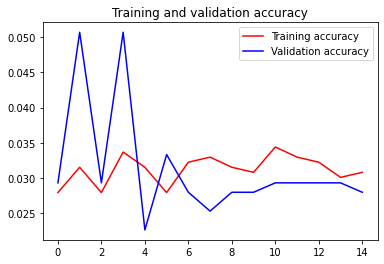

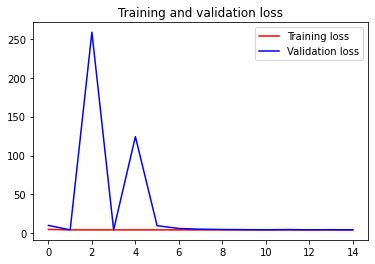

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def pred(fn):
  path =  fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  img = mpimg.imread(fn)
  imgplot = plt.imshow(img)
  plt.show()
  

In [ ]:
train['image_id'][0]

[0.36237746]


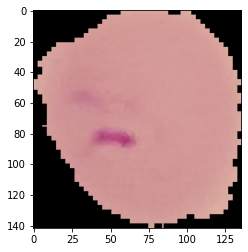

image is a parasitized


In [ ]:
pred('/content/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_140.png')